In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

In [2]:
customers=pd.read_csv('/content/drive/MyDrive/zeotap/Customers.csv')

In [3]:
transactions=pd.read_csv('/content/drive/MyDrive/zeotap/Transactions.csv')

In [4]:
merged_data = pd.merge(transactions, customers, on="CustomerID")

In [5]:
merged_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [6]:
merged_data.shape

(1000, 10)

In [7]:
# Feature Engineering: Calculate total spending, number of transactions, and average transaction value
customer_summary = merged_data.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    NumTransactions=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean")
).reset_index()

In [8]:
customer_summary.head()

,CustomerID,TotalSpending,NumTransactions,AvgTransactionValue
0,C0001,3354.52,5,670.904
1,C0002,1862.74,4,465.685
2,C0003,2725.38,4,681.345
3,C0004,5354.88,8,669.360
4,C0005,2034.24,3,678.080


In [9]:
# Merge with customer data to include additional features (e.g., Region)
customer_summary = pd.merge(customer_summary, customers, on="CustomerID")

In [10]:
customer_summary.head()

,CustomerID,TotalSpending,NumTransactions,AvgTransactionValue,CustomerName,Region,SignupDate
0,C0001,3354.52,5,670.904,Lawrence Carroll,South America,2022-07-10
1,C0002,1862.74,4,465.685,Elizabeth Lutz,Asia,2022-02-13
2,C0003,2725.38,4,681.345,Michael Rivera,South America,2024-03-07
3,C0004,5354.88,8,669.360,Kathleen Rodriguez,South America,2022-10-09
4,C0005,2034.24,3,678.080,Laura Weber,Asia,2022-08-15


In [11]:
customer_summary.shape

(199, 7)

In [12]:
# Select relevant features for clustering
features = customer_summary[["TotalSpending", "NumTransactions", "AvgTransactionValue"]]


In [13]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [14]:
features

,TotalSpending,NumTransactions,AvgTransactionValue
0,3354.52,5,670.904000
1,1862.74,4,465.685000
2,2725.38,4,681.345000
3,5354.88,8,669.360000
4,2034.24,3,678.080000
...,...,...,...
194,4982.88,4,1245.720000
195,1928.65,3,642.883333
196,931.83,2,465.915000
197,1979.28,4,494.820000


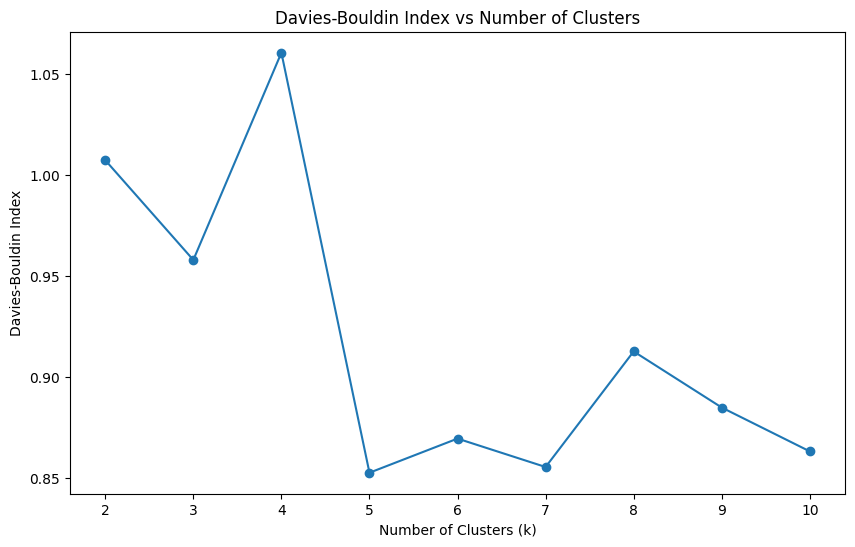

In [15]:
# Calculate Davies-Bouldin Index for different numbers of clusters
db_scores = []
k_values = range(2, 11)  # Test 2 to 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))

# Plot the Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(k_values, db_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.show()

In [17]:
db_scores

[1.0072253641525208,
 0.9578205962311453,
 1.0604240399923033,
 0.8524813520458038,
 0.8693770662816185,
 0.8553114327404956,
 0.9125320039336968,
 0.8847550123525418,
 0.8630460126564934]

In [18]:
# Choose the optimal number of clusters (replace `optimal_k` with the value from the plot)
optimal_k = k_values[db_scores.index(min(db_scores))]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_summary["Cluster"] = kmeans.fit_predict(scaled_features)

# Add cluster labels to the customer summary
print(customer_summary.head())

  CustomerID  TotalSpending  NumTransactions  AvgTransactionValue  \
0      C0001        3354.52                5              670.904   
1      C0002        1862.74                4              465.685   
2      C0003        2725.38                4              681.345   
3      C0004        5354.88                8              669.360   
4      C0005        2034.24                3              678.080   

         CustomerName         Region  SignupDate  Cluster  
0    Lawrence Carroll  South America  2022-07-10        4  
1      Elizabeth Lutz           Asia  2022-02-13        1  
2      Michael Rivera  South America  2024-03-07        3  
3  Kathleen Rodriguez  South America  2022-10-09        0  
4         Laura Weber           Asia  2022-08-15        3  


In [19]:
# Group by cluster and calculate mean values of features
cluster_analysis = customer_summary.groupby("Cluster").agg({
    "TotalSpending": "mean",
    "NumTransactions": "mean",
    "AvgTransactionValue": "mean"
}).reset_index()

print(cluster_analysis)

   Cluster  TotalSpending  NumTransactions  AvgTransactionValue
0        0    6236.275278         7.888889           800.215188
1        1    1125.417419         2.935484           372.112215
2        2    4327.404815         4.111111          1066.046222
3        3    2163.799024         3.048780           730.433882
4        4    3516.344062         6.078125           589.909275


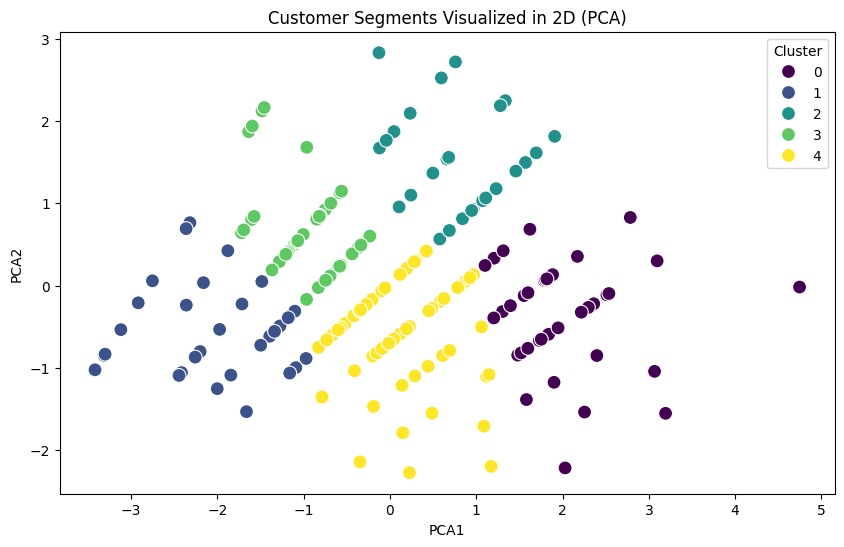

In [20]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the dataframe
customer_summary["PCA1"] = pca_result[:, 0]
customer_summary["PCA2"] = pca_result[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="Cluster",
    palette="viridis",
    data=customer_summary,
    s=100
)
plt.title("Customer Segments Visualized in 2D (PCA)")
plt.show()

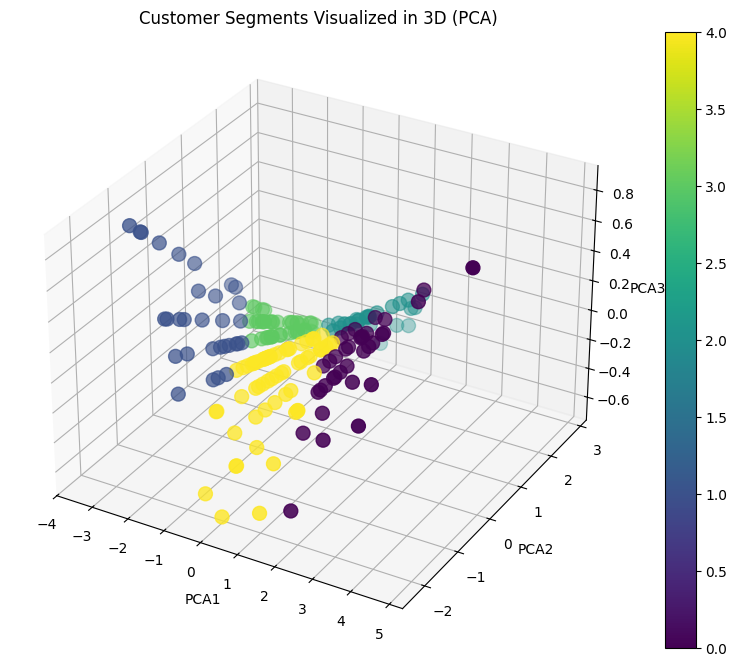

In [21]:

from mpl_toolkits.mplot3d import Axes3D

# Reduce dimensions to 3D using PCA
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(scaled_features)

# Add PCA results to the dataframe
customer_summary["PCA1_3D"] = pca_3d_result[:, 0]
customer_summary["PCA2_3D"] = pca_3d_result[:, 1]
customer_summary["PCA3_3D"] = pca_3d_result[:, 2]

# Plot 3D PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    customer_summary["PCA1_3D"],
    customer_summary["PCA2_3D"],
    customer_summary["PCA3_3D"],
    c=customer_summary["Cluster"],
    cmap="viridis",
    s=100
)
plt.colorbar(scatter)
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
plt.title("Customer Segments Visualized in 3D (PCA)")
plt.show()